In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
from rdkit.Chem import RDConfig, rdMolDescriptors, Descriptors, PandasTools
from syba.syba import SybaClassifier
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

root = os.path.dirname(os.getcwd())

## Compute other scores and metrics

In [ ]:
def calc_SAscore(mol):
    return sascorer.calculateScore(mol)

scscore_path = os.path.join(root, 'scscore')
sys.path.append(scscore_path)
from scscore.standalone_model_numpy import SCScorer
model_sc = SCScorer()
model_sc.restore(os.path.join(scscore_path, 'models', 'full_reaxys_model_2048bool', 'model.ckpt-10654.as_numpy.pickle'), FP_len=2048)

def calc_SCscore(smi):
    smi, score = model_sc.get_score_from_smi(smi)
    return score

syba = SybaClassifier()
syba.fitDefaultScore()

def calc_SYBA(smi, mol = None):
    # takes very long
    score = syba.predict(smi=smi, mol=mol)
    return score

def calc_logP(mol):
    return rdMolDescriptors.CalcCrippenDescriptors(mol)[0]

def calc_QED(mol):
    return Descriptors.qed(mol)

def calc_MW(mol):
    return Descriptors.MolWt(mol)

def calc_numheavyatoms(mol):
    return mol.GetNumHeavyAtoms()

In [ ]:
df_graph = pd.read_csv('/home/rebecca/code/intuitive-sc/results/uspto_cjhif_combo_test_reorder_combo_train_graph_sub100000_ep20_2023-07-11_scores.csv')
df_fp = pd.read_csv('/home/rebecca/code/intuitive-sc/results/uspto_cjhif_combo_test_reorder_combo_train_fp_sub100000_ep20_2023-07-07_scores.csv')
df_graph.head()

In [ ]:
# add mols
PandasTools.AddMoleculeColumnToFrame(df_graph, smilesCol='smiles_i', molCol='mol_i')
PandasTools.AddMoleculeColumnToFrame(df_fp, smilesCol='smiles_i', molCol='mol_i')

In [ ]:
from pathos import multiprocessing as mp
from tqdm import tqdm
import numpy as np

def chunked_parallel(input_list, function, chunks = 1000, max_cpu = 20): 
    """chunked_parallel

    Args:
        input_list : list of objects to apply function
        function : Callable with 1 input and returning a single value
        chunks: number of chunks
        max_cpu: Max num cpus
    """

    cpus = min(mp.cpu_count(), max_cpu)
    pool = mp.Pool(processes = cpus)

    def batch_func(list_inputs): 
        outputs = []
        for i in list_inputs: 
            outputs.append(function(i))
        return outputs

    list_len = len(input_list)
    num_chunks = min(list_len, chunks)
    step_size = len(input_list) // num_chunks

    chunked_list = [input_list[i:i+step_size] 
                    for i in range(0, len(input_list), step_size)]

    list_outputs = list(tqdm(pool.imap(batch_func, chunked_list),
                             total=num_chunks))
    full_output = [j for i in list_outputs for j in i]
    return full_output

In [ ]:
def calc_all_scores(df, mol_col = 'mol_i', smiles_col = 'smiles_i'):
    df['SA_score'] = chunked_parallel(df[mol_col], calc_SAscore)
    df['SC_score'] = chunked_parallel(df[smiles_col], calc_SCscore)
    df['SYBA_score'] = chunked_parallel(df[smiles_col], calc_SYBA)
    df['logP'] = chunked_parallel(df[mol_col], calc_logP)
    df['QED'] = chunked_parallel(df[mol_col], calc_QED)
    df['MW'] = chunked_parallel(df[mol_col], calc_MW)
    df['numheavyatoms'] = chunked_parallel(df[mol_col], calc_numheavyatoms)
    return df

In [ ]:
df_fp = calc_all_scores(df_fp)
df_fp.head()

In [ ]:
df_graph = calc_all_scores(df_graph)
df_graph.head()

In [ ]:
df_ra_fp = pd.read_csv('/home/rebecca/code/intuitive-sc/results/combo_test_fp_sub100000_ep20_2023-07-07_RAscores.csv')
df_ra_graph = pd.read_csv('/home/rebecca/code/intuitive-sc/results/combo_test_graph_sub100000_ep20_2023-07-11_RAscores.csv')
df_ra_fp.head()

In [ ]:
df_fp = pd.read_csv('/home/rebecca/code/intuitive-sc/results/combo_test_fp_sub100000_ep20_2023-07-07_scores_all.csv')
df_graph = pd.read_csv('/home/rebecca/code/intuitive-sc/results/combo_test_graph_sub100000_ep20_2023-07-11_scores_all.csv')
df_fp.head()

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_fp, smilesCol='smiles_i', molCol='mol_i')
PandasTools.AddMoleculeColumnToFrame(df_graph, smilesCol='smiles_i', molCol='mol_i')

In [ ]:
# add RA score to full df
df_fp['RAscore'] = df_ra_fp['RAscore']
df_graph['RAscore'] = df_ra_graph['RAscore']

In [ ]:
df_fp.drop(columns=['mol_i'], inplace=True)
df_fp.to_csv('/home/rebecca/code/intuitive-sc/results/combo_test_fp_sub100000_ep20_2023-07-07_scores_all.csv', index=False)
df_graph.drop(columns=['mol_i'], inplace=True)
df_graph.to_csv('/home/rebecca/code/intuitive-sc/results/combo_test_graph_sub100000_ep20_2023-07-11_scores_all.csv', index=False)

## Analysis

In [43]:
df_fp = pd.read_csv('/home/rebecca/code/intuitive-sc/results/syba_testset_fpscored.csv')
df_graph = pd.read_csv('/home/rebecca/code/intuitive-sc/results/syba_testset_graphscored.csv')
smi_col = 'smi'

In [44]:
# deduplicate for analysis
df_fp = df_fp.drop_duplicates(subset=[smi_col])
df_graph = df_graph.drop_duplicates(subset=[smi_col])
df_fp = df_fp[df_fp['source'] == 'MC']
df_graph = df_graph[df_graph['source'] == 'MC']
df_fp.reset_index(inplace=True)
df_graph.reset_index(inplace=True)

### Plot correlations

In [45]:
from scipy.stats import pearsonr

def plot_scatter(ax, x1, y1, x2, y2, ylabel):
    pcc_fp = pearsonr(x1, y1)[0]
    pcc_graph = pearsonr(x2, y2)[0]
    ax.scatter(x1, y1, alpha = 0.3, label = f'FP (PCC={pcc_fp:.3f})', s=2);
    ax.scatter(x2, y2, alpha = 0.3, label = f'Graph (PCC={pcc_graph:.3f})', s=2);
    ax.set_xlabel('ours');
    ax.set_ylabel(ylabel);
    ax.legend(loc='lower left');
    ax.set_title(ylabel);
    return pcc_fp, pcc_graph

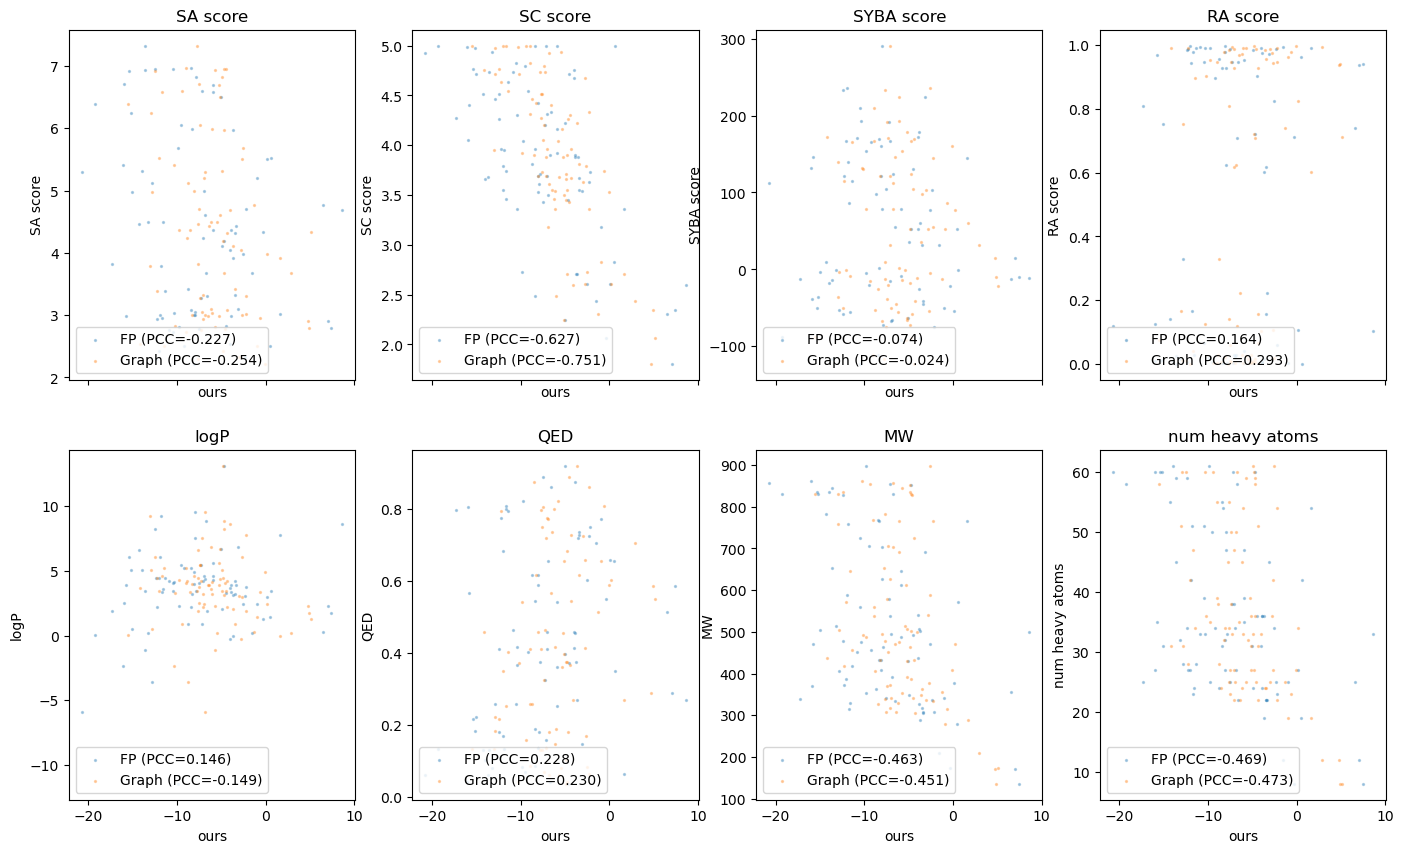

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,4,figsize=(17, 10), sharex=True)

pcc_fp_new_sa, pcc_graph_new_sa = plot_scatter(axs[0,0], df_fp['score'], df_fp['SA_score'], df_graph['score'], df_graph['SA_score'], 'SA score')
pcc_fp_new_sc, pcc_graph_new_sc = plot_scatter(axs[0,1], df_fp['score'], df_fp['SC_score'], df_graph['score'], df_graph['SC_score'], 'SC score')
pcc_fp_new_syba, pcc_graph_new_syba = plot_scatter(axs[0,2], df_fp['score'], df_fp['SYBA_score'], df_graph['score'], df_graph['SYBA_score'], 'SYBA score')
pcc_fp_new_ra, pcc_graph_new_ra = plot_scatter(axs[0,3], df_fp['score'], df_fp['RAscore'], df_graph['score'], df_graph['RAscore'], 'RA score')
pcc_fp_new_logp, pcc_graph_new_logp = plot_scatter(axs[1,0], df_fp['score'], df_fp['logP'], df_graph['score'], df_graph['logP'], 'logP')
pcc_fp_new_qed, pcc_graph_new_qed = plot_scatter(axs[1,1], df_fp['score'], df_fp['QED'], df_graph['score'], df_graph['QED'], 'QED')
pcc_fp_new_mw, pcc_graph_new_mw = plot_scatter(axs[1,2], df_fp['score'], df_fp['MW'], df_graph['score'], df_graph['MW'], 'MW')
pcc_fp_new_natoms, pcc_graph_new_natoms = plot_scatter(axs[1,3], df_fp['score'], df_fp['numheavyatoms'], df_graph['score'], df_graph['numheavyatoms'], 'num heavy atoms')

Text(0.7, 0.05, 'PCC=0.699')

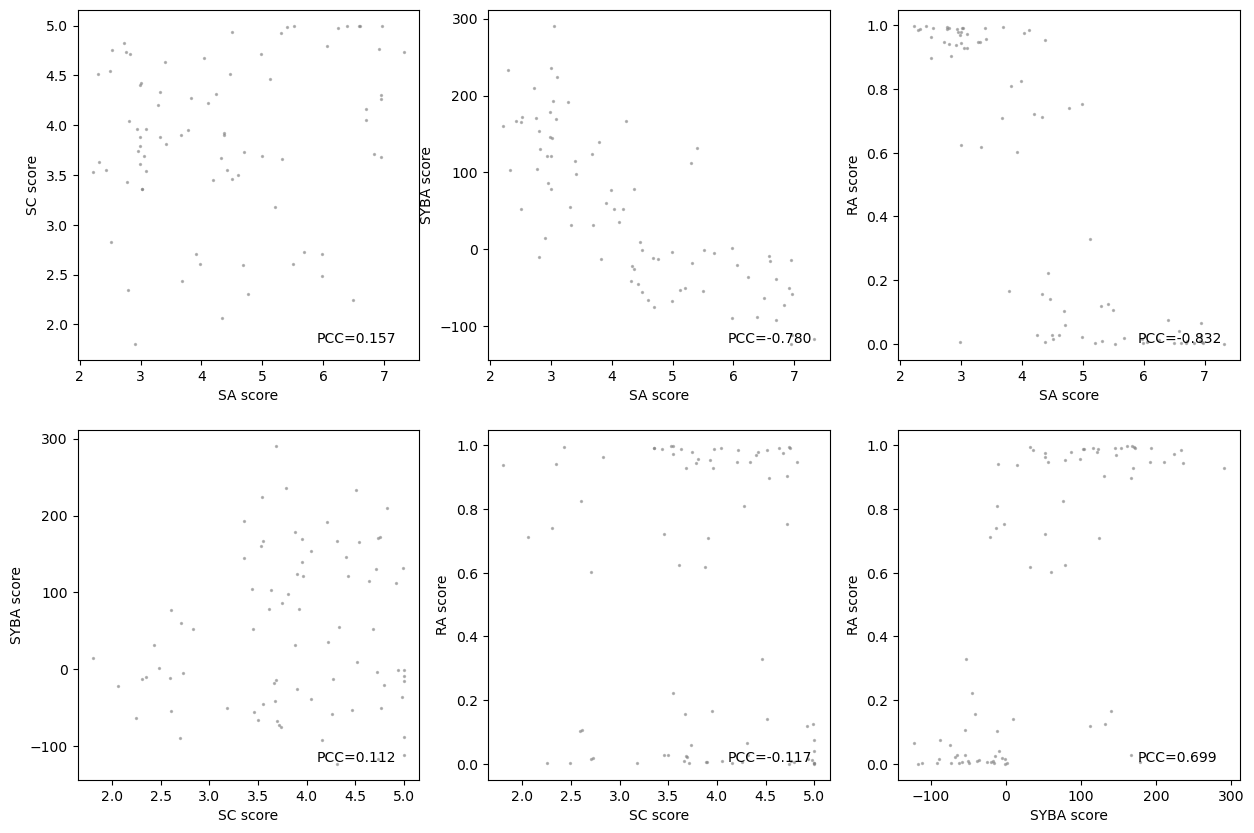

In [47]:
# correlations between old scores themselves

fig, axs = plt.subplots(2,3,figsize=(15, 10))

pccsa_sc = pearsonr(df_fp['SA_score'], df_fp['SC_score'])[0]
pccsa_syba = pearsonr(df_fp['SA_score'], df_fp['SYBA_score'])[0]
pccsa_ra = pearsonr(df_fp['SA_score'], df_fp['RAscore'])[0]
axs[0,0].scatter(df_fp['SA_score'], df_fp['SC_score'], alpha = 0.5, label = f'PCC={pccsa_sc:.3f}', s=2, color='grey');
axs[0,0].set_xlabel('SA score');
axs[0,0].set_ylabel('SC score');
axs[0,0].text(0.7, 0.05, f'PCC={pccsa_sc:.3f}', transform=axs[0,0].transAxes)

axs[0,1].scatter(df_fp['SA_score'], df_fp['SYBA_score'], alpha = 0.5, label = f'PCC={pccsa_syba:.3f}', s=2, color='grey');
axs[0,1].set_xlabel('SA score');
axs[0,1].set_ylabel('SYBA score');
axs[0,1].text(0.7, 0.05, f'PCC={pccsa_syba:.3f}', transform=axs[0,1].transAxes)

axs[0,2].scatter(df_fp['SA_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsa_ra:.3f}', s=2, color='grey');
axs[0,2].set_xlabel('SA score');
axs[0,2].set_ylabel('RA score');
axs[0,2].text(0.7, 0.05, f'PCC={pccsa_ra:.3f}', transform=axs[0,2].transAxes)

pccsc_syba = pearsonr(df_fp['SC_score'], df_fp['SYBA_score'])[0]
pccsc_ra = pearsonr(df_fp['SC_score'], df_fp['RAscore'])[0]
axs[1,0].scatter(df_fp['SC_score'], df_fp['SYBA_score'], alpha = 0.5, label = f'PCC={pccsc_syba:.3f}', s=2, color='grey');
axs[1,0].set_xlabel('SC score');
axs[1,0].set_ylabel('SYBA score');
axs[1,0].text(0.7, 0.05, f'PCC={pccsc_syba:.3f}', transform=axs[1,0].transAxes)

axs[1,1].scatter(df_fp['SC_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsc_ra:.3f}', s=2, color='grey');
axs[1,1].set_xlabel('SC score');
axs[1,1].set_ylabel('RA score');
axs[1,1].text(0.7, 0.05, f'PCC={pccsc_ra:.3f}', transform=axs[1,1].transAxes)

pccsyba_ra = pearsonr(df_fp['SYBA_score'], df_fp['RAscore'])[0]
axs[1,2].scatter(df_fp['SYBA_score'], df_fp['RAscore'], alpha = 0.5, label = f'PCC={pccsyba_ra:.3f}', s=2, color='grey');
axs[1,2].set_xlabel('SYBA score');
axs[1,2].set_ylabel('RA score');
axs[1,2].text(0.7, 0.05, f'PCC={pccsyba_ra:.3f}', transform=axs[1,2].transAxes)

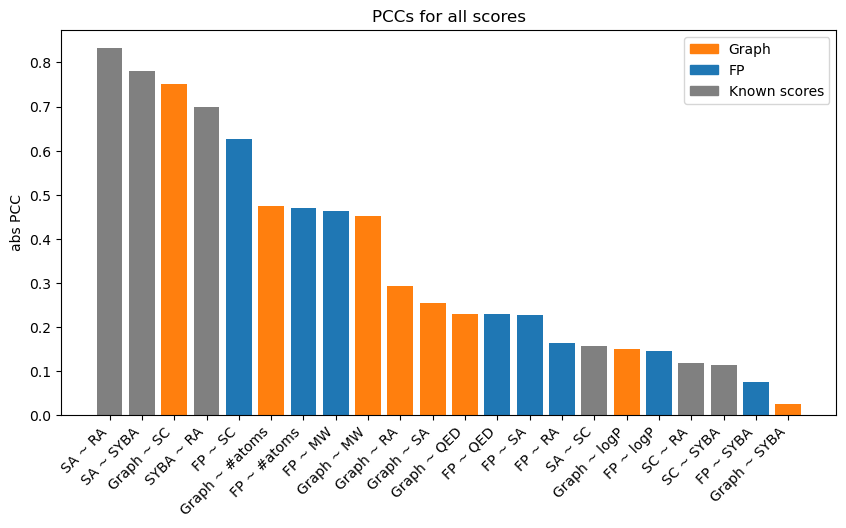

In [48]:
# barplots of correlations
import matplotlib.patches as mpatches
pccs_fp = [pcc_fp_new_sa, pcc_fp_new_sc, pcc_fp_new_syba, pcc_fp_new_ra, pcc_fp_new_logp, pcc_fp_new_qed, pcc_fp_new_mw, pcc_fp_new_natoms]
pccs_graph = [pcc_graph_new_sa, pcc_graph_new_sc, pcc_graph_new_syba, pcc_graph_new_ra, pcc_graph_new_logp, pcc_graph_new_qed, pcc_graph_new_mw, pcc_graph_new_natoms]
pccs_old = [pccsa_sc, pccsa_syba, pccsa_ra, pccsc_syba, pccsc_ra, pccsyba_ra]

ppcs_all = pccs_fp + pccs_graph + pccs_old

# color list based on fp, graph, old
colors = ['tab:blue']*8 + ['tab:orange']*8 + ['grey']*6

# legends
legends = ['FP ~ SA', 'FP ~ SC', 'FP ~ SYBA', 'FP ~ RA', 'FP ~ logP', 'FP ~ QED', 'FP ~ MW', 'FP ~ #atoms', 'Graph ~ SA', 'Graph ~ SC', 'Graph ~ SYBA', 'Graph ~ RA', 'Graph ~ logP', 'Graph ~ QED', 'Graph ~ MW', 'Graph ~ #atoms', 'SA ~ SC', 'SA ~ SYBA', 'SA ~ RA', 'SC ~ SYBA', 'SC ~ RA', 'SYBA ~ RA']

# get absolute values
ppcs_all = [abs(x) for x in ppcs_all]

# make dictionary with colors
color_dict = dict(zip(ppcs_all, colors))
legends_dict = dict(zip(ppcs_all, legends))

# sort by descending order
ppcs_all.sort(reverse=True)

# get colors and legends in same order
colors_sorted = [color_dict[x] for x in ppcs_all]
legends_sorted = [legends_dict[x] for x in ppcs_all]

# plot absolute values
plt.figure(figsize=(10,5));
plt.bar(range(len(ppcs_all)), ppcs_all, color=colors_sorted);
plt.xticks(range(len(ppcs_all)), legends_sorted, rotation=45, ha='right');
plt.ylabel('abs PCC');
plt.title('PCCs for all scores');

graph_patch = mpatches.Patch(color='tab:orange', label='Graph');
fp_patch = mpatches.Patch(color='tab:blue', label='FP');
old_patch = mpatches.Patch(color='grey', label='Known scores');
plt.legend(handles=[graph_patch, fp_patch, old_patch]);


### Visualize examples

In [49]:
# display top and bottom 10 molecules with their scores
df_fp.sort_values(by=['score'], inplace=True)
df_graph.sort_values(by=['score'], inplace=True)

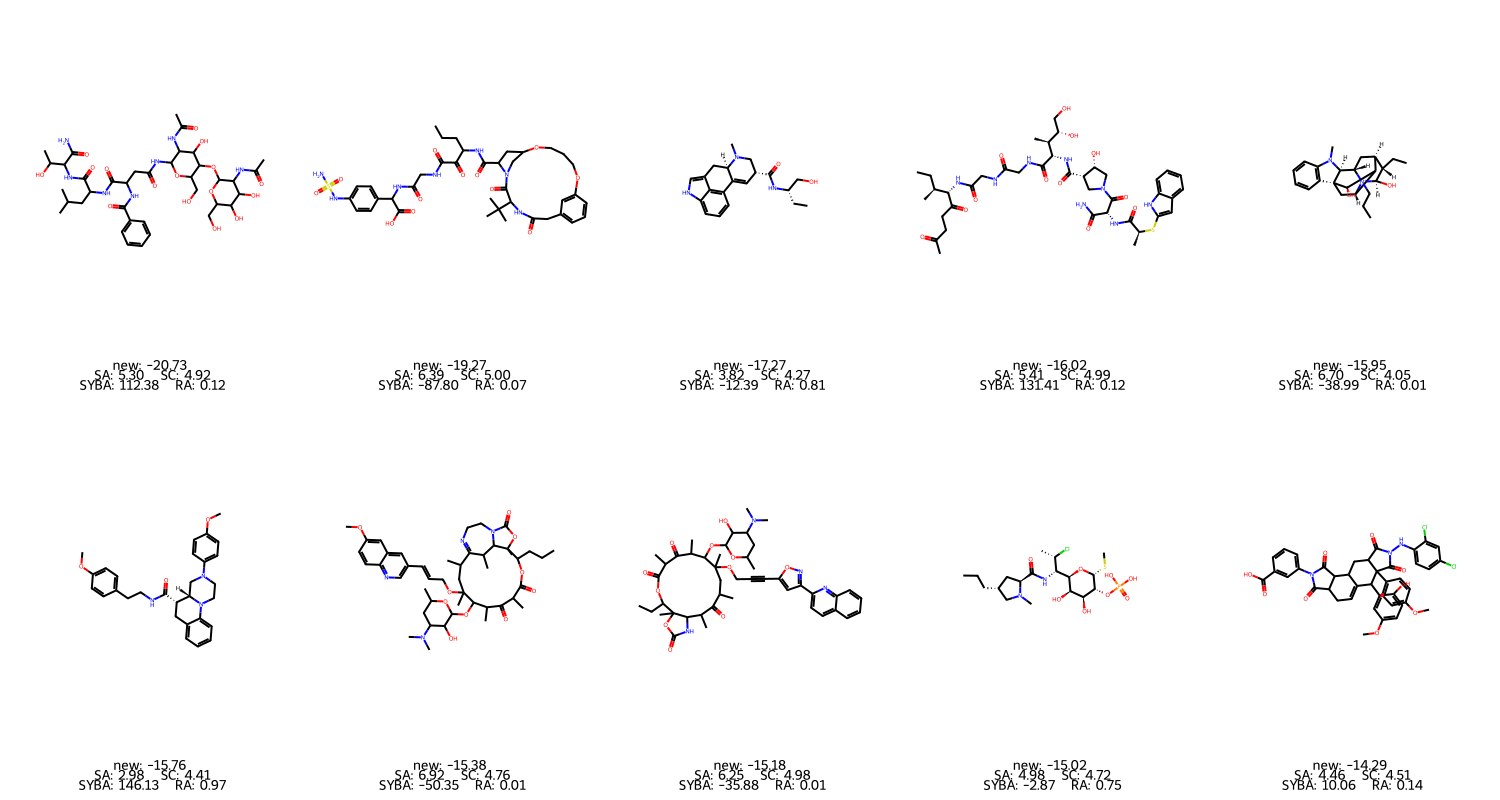

In [50]:
n = 10
bottom_smi = df_fp[smi_col].head(n).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores = df_fp['score'].head(n).tolist()
bottom_sa = df_fp['SA_score'].head(n).tolist()
bottom_sc = df_fp['SC_score'].head(n).tolist()
bottom_syba = df_fp['SYBA_score'].head(n).tolist()
bottom_ra = df_fp['RAscore'].head(n).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\n SA: {sa:.2f}\t SC: {sc:.2f}\n SYBA: {syba:.2f}\t RA: {ra:.2f}'
              for new, sa, sc, syba, ra in zip(bottom_scores, bottom_sa, bottom_sc, bottom_syba, bottom_ra)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

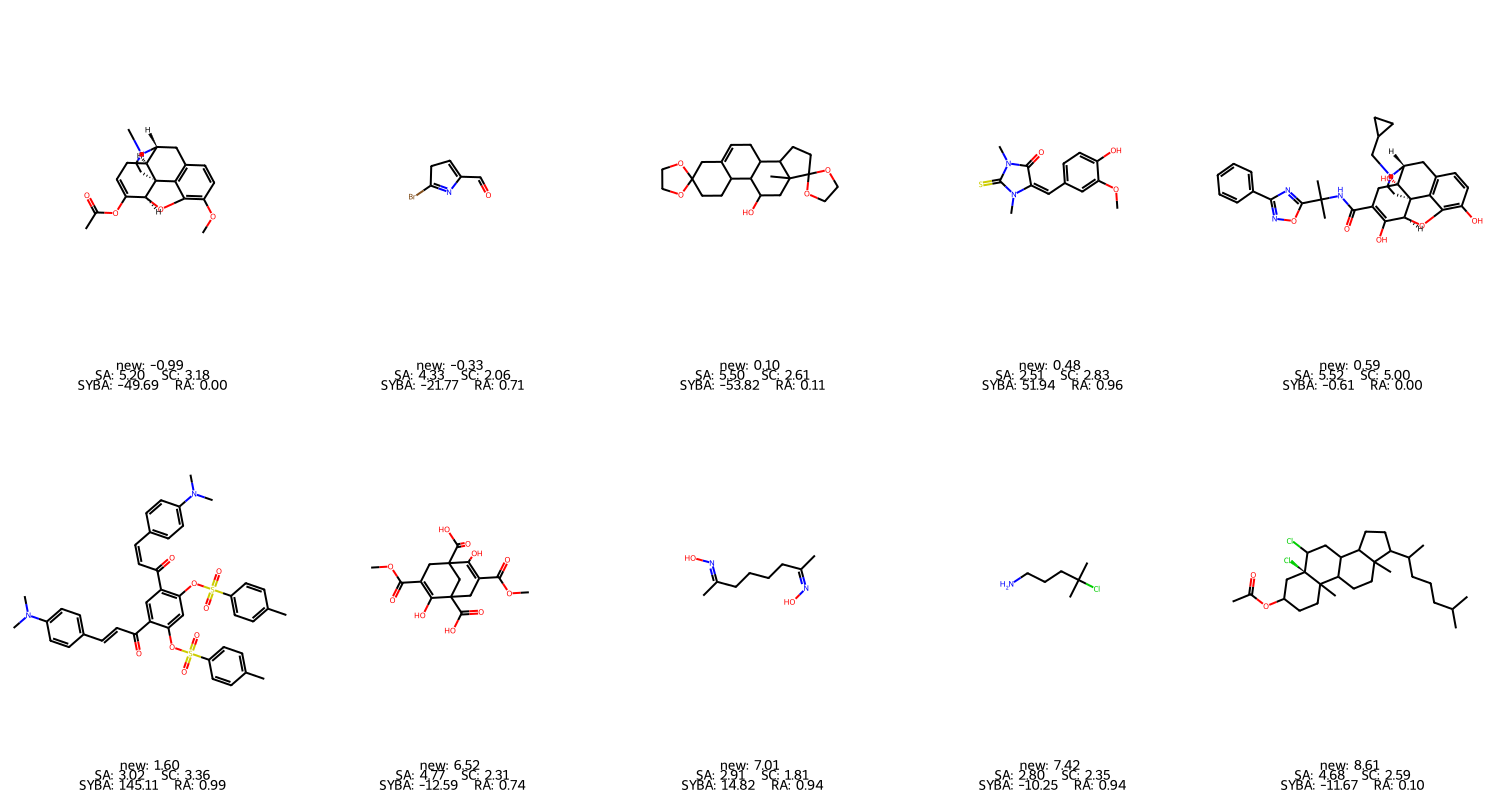

In [51]:
top_smi = df_fp[smi_col].tail(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores = df_fp['score'].tail(10).tolist()
top_sa = df_fp['SA_score'].tail(10).tolist()
top_sc = df_fp['SC_score'].tail(10).tolist()
top_syba = df_fp['SYBA_score'].tail(10).tolist()
top_ra = df_fp['RAscore'].tail(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\n SA: {sa:.2f}\t SC: {sc:.2f}\n SYBA: {syba:.2f}\t RA: {ra:.2f}'
              for new, sa, sc, syba, ra in zip(top_scores, top_sa, top_sc, top_syba, top_ra)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

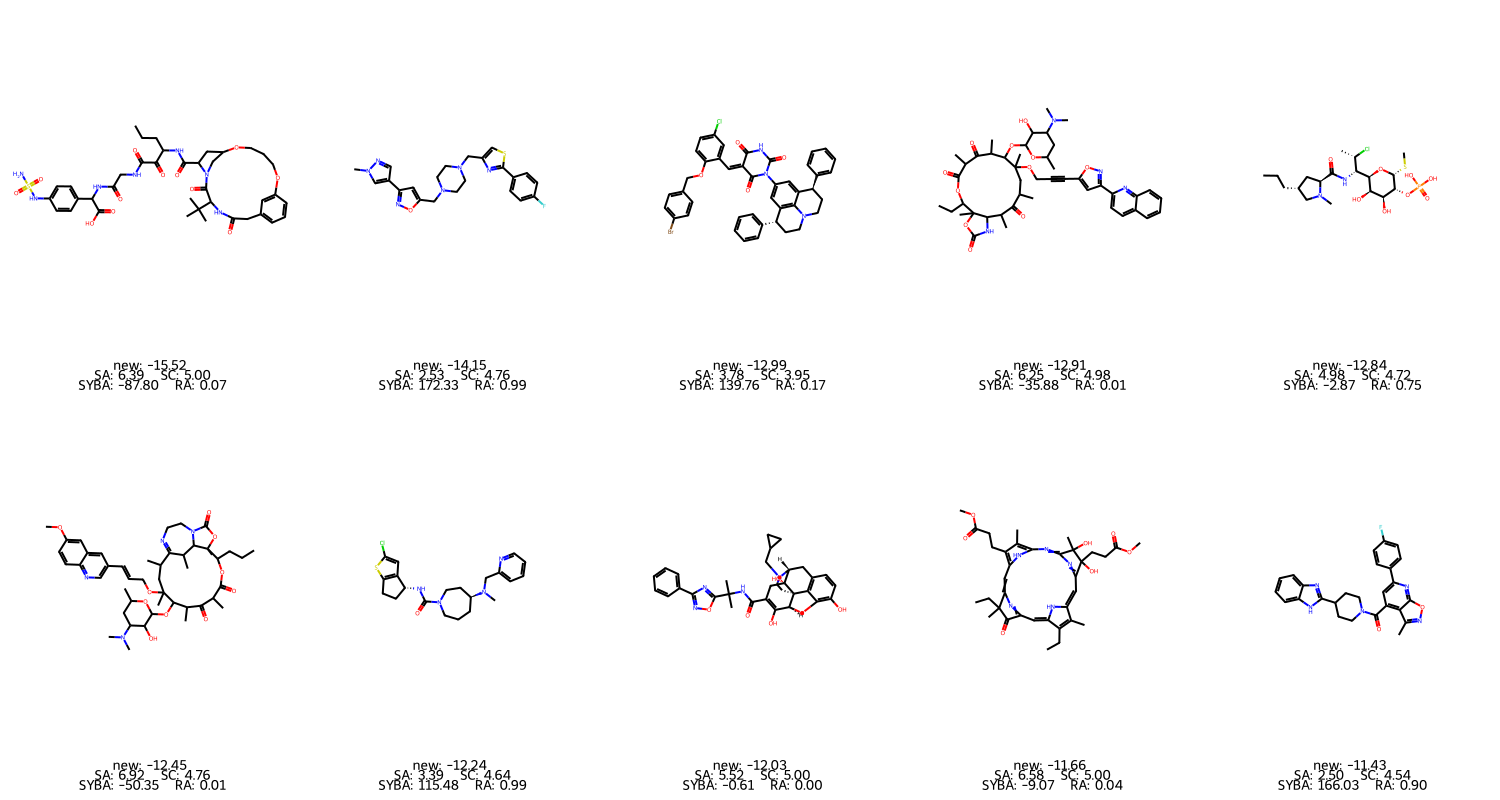

In [52]:
bottom_smi = df_graph[smi_col].head(n).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores = df_graph['score'].head(n).tolist()
bottom_sa = df_graph['SA_score'].head(n).tolist()
bottom_sc = df_graph['SC_score'].head(n).tolist()
bottom_syba = df_graph['SYBA_score'].head(n).tolist()
bottom_ra = df_graph['RAscore'].head(n).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\n SA: {sa:.2f}\t SC: {sc:.2f}\n SYBA: {syba:.2f}\t RA: {ra:.2f}'
              for new, sa, sc, syba, ra in zip(bottom_scores, bottom_sa, bottom_sc, bottom_syba, bottom_ra)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

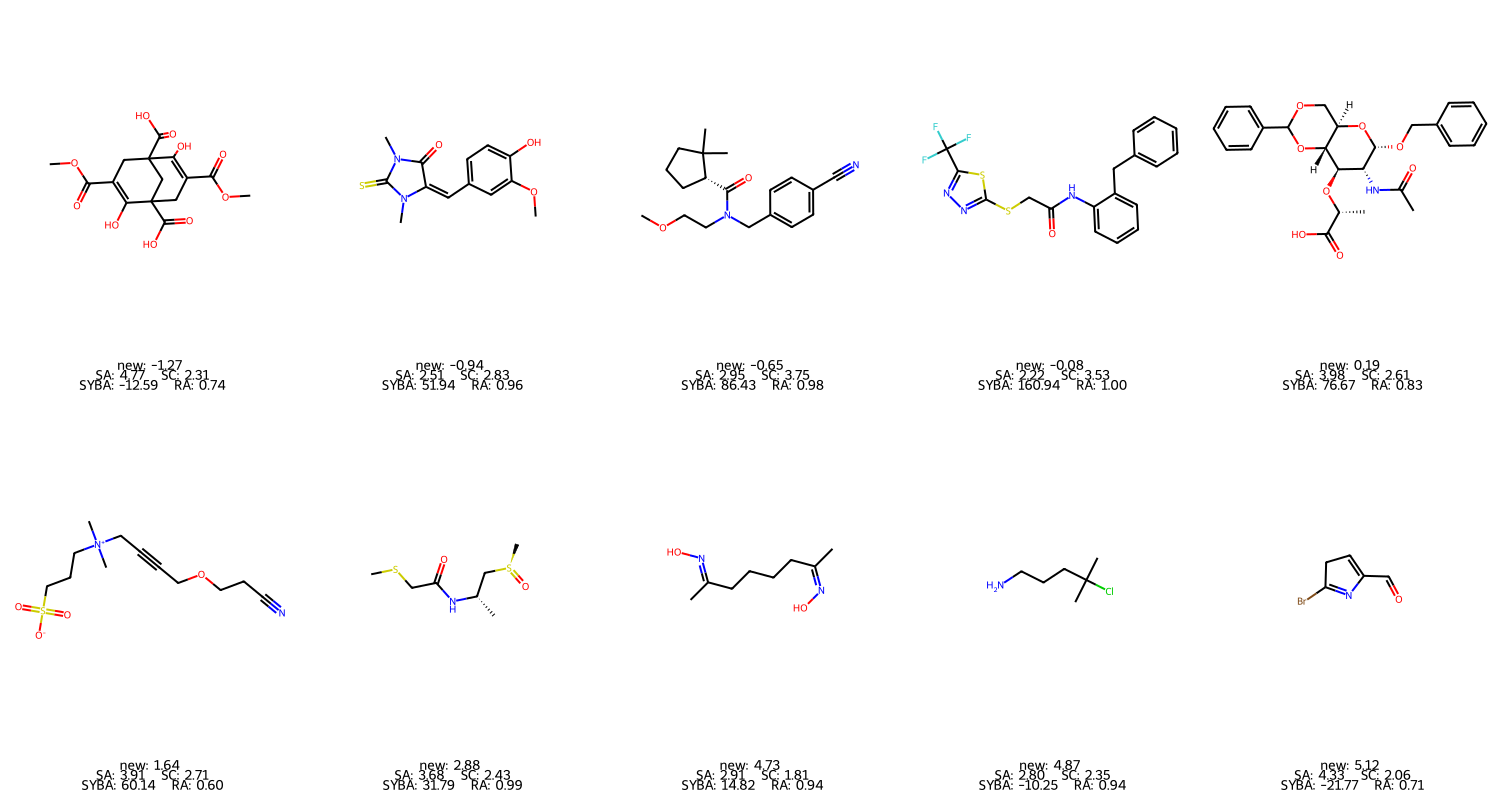

In [53]:
top_smi = df_graph[smi_col].tail(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores = df_graph['score'].tail(10).tolist()
top_sa = df_graph['SA_score'].tail(10).tolist()
top_sc = df_graph['SC_score'].tail(10).tolist()
top_syba = df_graph['SYBA_score'].tail(10).tolist()
top_ra = df_graph['RAscore'].tail(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'new: {new:.2f}\n SA: {sa:.2f}\t SC: {sc:.2f}\n SYBA: {syba:.2f}\t RA: {ra:.2f}'
              for new, sa, sc, syba, ra in zip(top_scores, top_sa, top_sc, top_syba, top_ra)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

In [54]:
# visualize those where the difference is the largest between FP and graph
df_combo = pd.merge(df_fp, df_graph, on=smi_col, suffixes=('_fp', '_graph'))
df_combo = df_combo[[smi_col, 'score_fp', 'score_graph']]
# drop columns that are not needed
df_combo['diff'] = df_combo['score_fp'] - df_combo['score_graph']
# absolute value
df_combo['abs_diff'] = df_combo['diff'].abs()
df_combo.head()

,smi,score_fp,score_graph,diff,abs_diff
0,CC(C)CC(NC(=O)C(CC(=O)NC2OC(CO)C(OC1OC(CO)C(O)...,-20.730,-6.785,-13.945,13.945
1,CCCC(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)Cc3cc...,-19.270,-15.516,-3.754,3.754
2,c12c3C4=C[C@H](CN([C@@H]4Cc1c[nH]c2ccc3)C)C(=O...,-17.270,-7.652,-9.618,9.618
3,CC[C@H](C)[C@H](NC(=O)CNC(=O)CNC(=O)[C@@H](NC(...,-16.020,-10.310,-5.710,5.710
4,c1ccc2c(c1)[C@@]13[C@@H](N2C)[C@H]2[N+]4([C@@H...,-15.945,-7.465,-8.480,8.480


In [55]:
# sort by descending order
df_combo.sort_values(by=['abs_diff'], inplace=True, ascending=False)
df_combo.head()

,smi,score_fp,score_graph,diff,abs_diff
0,CC(C)CC(NC(=O)C(CC(=O)NC2OC(CO)C(OC1OC(CO)C(O)...,-20.7300,-6.785,-13.9450,13.9450
79,CC(=O)OC1C[C@]2(Cl)C(Cl)CC3C4CCC(C(C)CCCC(C)C)...,8.6100,-4.043,12.6530,12.6530
74,c1(c2c3c(cc1)C[C@@H]1[C@]4([C@@]3([C@H](C(=C(C...,0.5933,-12.030,12.6233,12.6233
21,COCCN(Cc1ccc(C#N)cc1)C(=O)[C@@H]1CCCC1(C)C,-11.6950,-0.652,-11.0430,11.0430
56,Cn1cc(-c2cc(CN3CCN(Cc4csc(-c5ccc(F)cc5)n4)CC3)...,-3.9980,-14.150,10.1520,10.1520


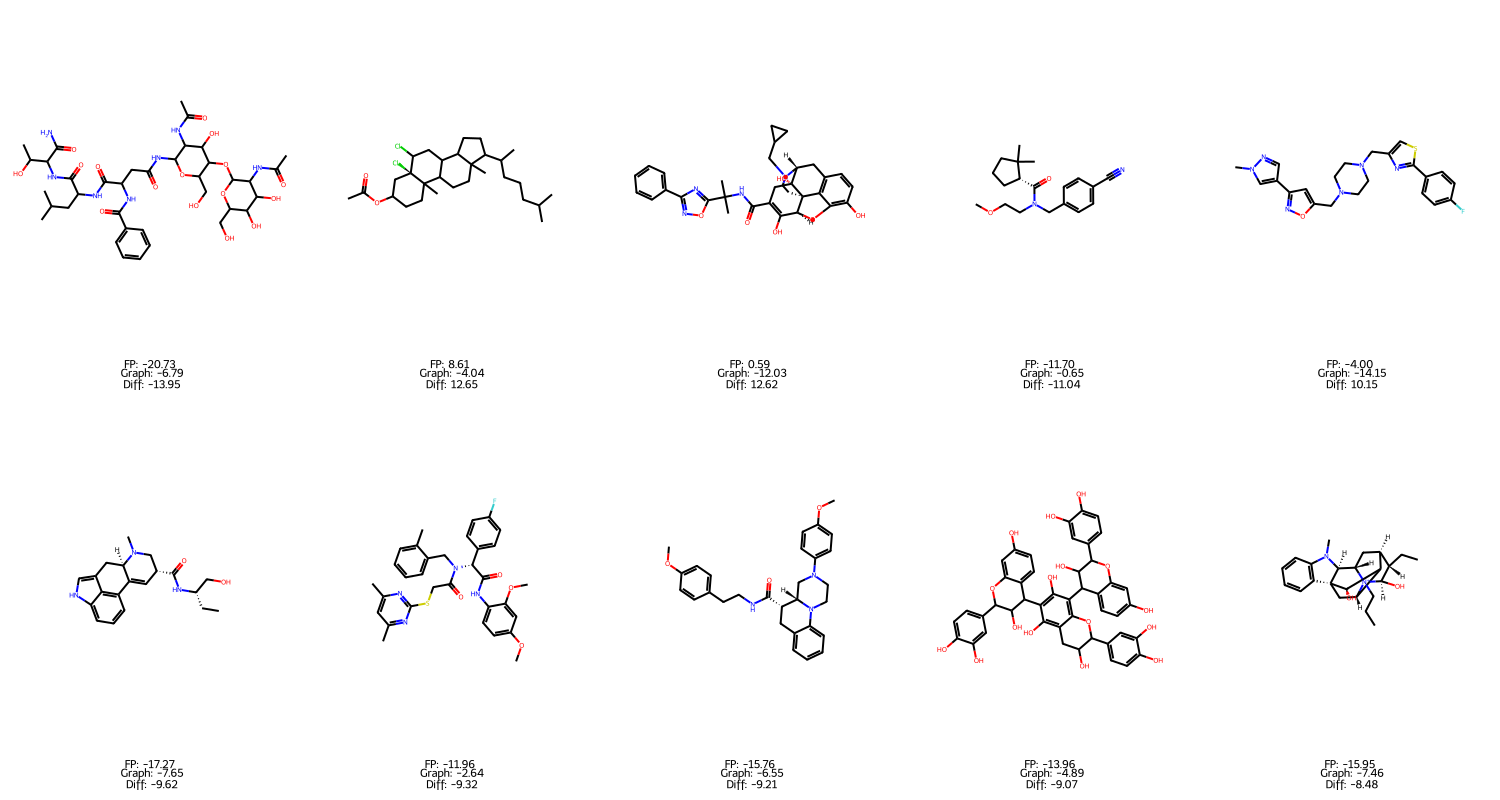

In [56]:
# show top 10
top_smi = df_combo[smi_col].head(10).tolist()
top_mols = [Chem.MolFromSmiles(smi) for smi in top_smi]
top_scores_fp = df_combo['score_fp'].head(10).tolist()
top_scores_graph = df_combo['score_graph'].head(10).tolist()
top_diff = df_combo['diff'].head(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'FP: {fp:.2f}\n Graph: {graph:.2f}\n Diff: {diff:.2f}'
                for fp, graph, diff in zip(top_scores_fp, top_scores_graph, top_diff)]
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

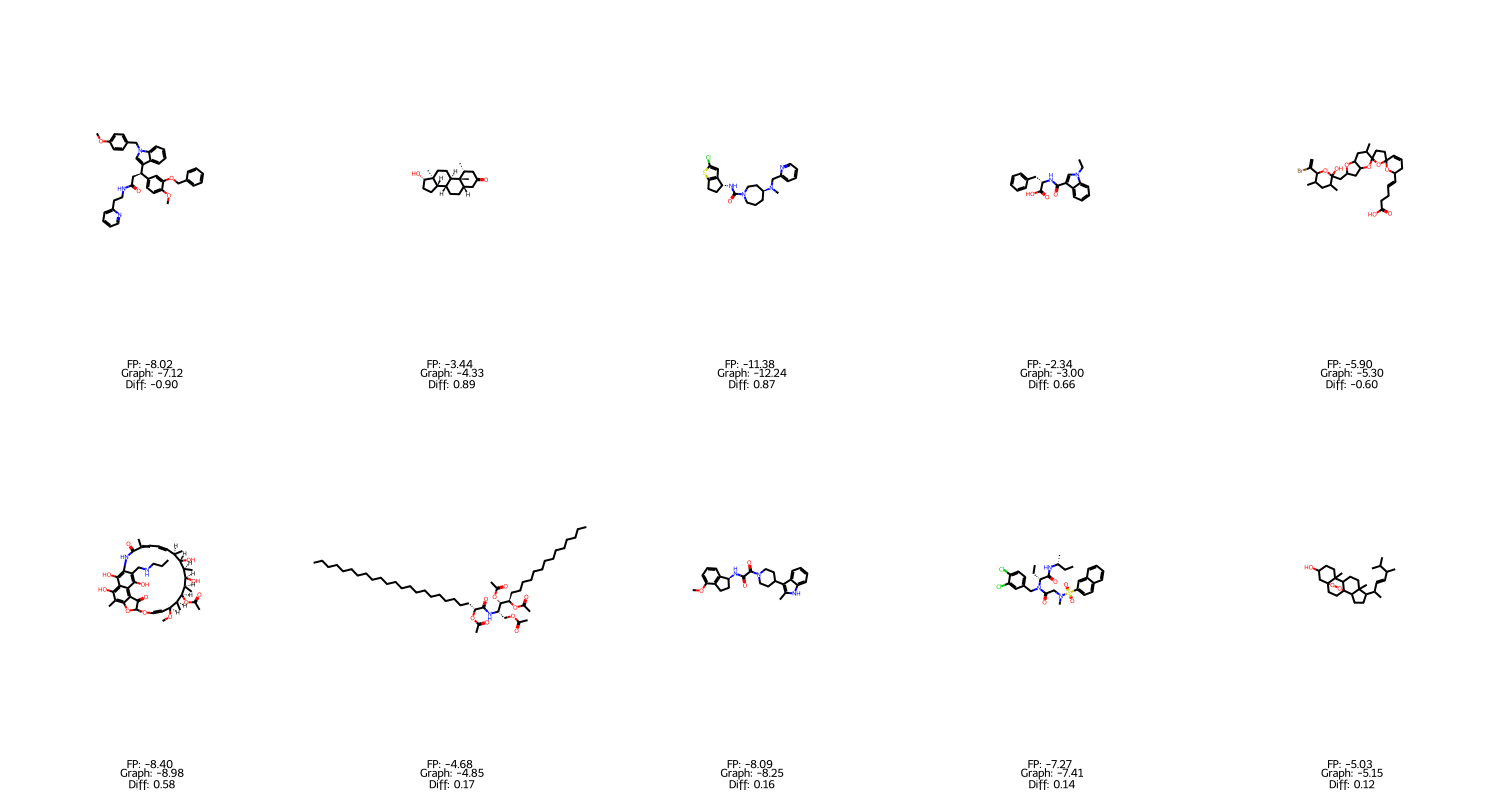

In [57]:
# show bottom 10
bottom_smi = df_combo[smi_col].tail(10).tolist()
bottom_mols = [Chem.MolFromSmiles(smi) for smi in bottom_smi]
bottom_scores_fp = df_combo['score_fp'].tail(10).tolist()
bottom_scores_graph = df_combo['score_graph'].tail(10).tolist()
bottom_diff = df_combo['diff'].tail(10).tolist()
# create legend texts for every mol by zipping the scores together
legends = [f'FP: {fp:.2f}\n Graph: {graph:.2f}\n Diff: {diff:.2f}'
                for fp, graph, diff in zip(bottom_scores_fp, bottom_scores_graph, bottom_diff)]
Chem.Draw.MolsToGridImage(bottom_mols, molsPerRow=5, legends=legends, subImgSize=(300,400))

### Distribution of values

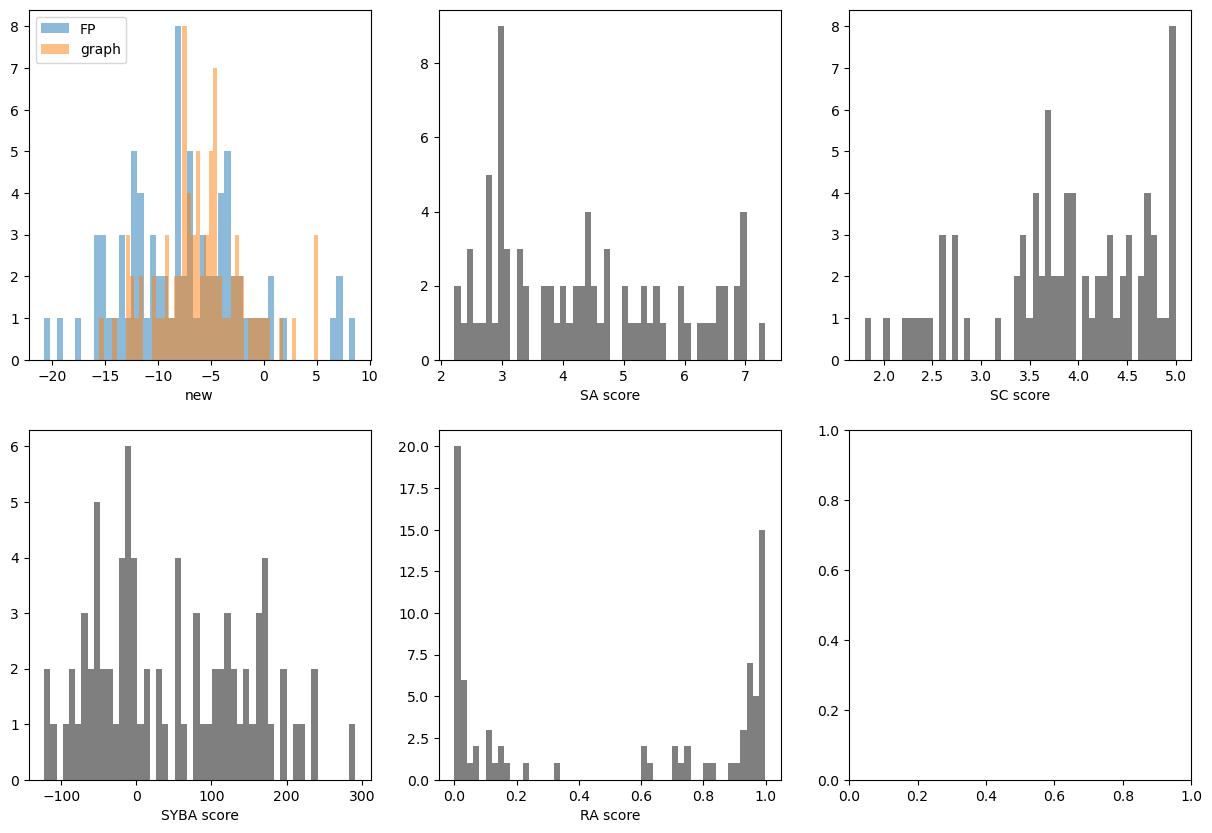

In [58]:
# plot histograms
fig, axs = plt.subplots(2,3,figsize=(15, 10))

bins = 50
alpha = 0.5
density=False
axs[0,0].hist(df_fp['score'], bins=bins, alpha=alpha, label='FP',density=density)
axs[0,0].set_xlabel('new');
axs[0,0].hist(df_graph['score'], bins=bins, alpha=alpha, label='graph', density=density)
axs[0,0].legend(loc='upper left');
axs[0,1].hist(df_fp['SA_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[0,1].set_xlabel('SA score');
axs[0,2].hist(df_fp['SC_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[0,2].set_xlabel('SC score');
axs[1,0].hist(df_fp['SYBA_score'], bins=bins, alpha=alpha, density=density, color='k')
axs[1,0].set_xlabel('SYBA score');
axs[1,1].hist(df_fp['RAscore'], bins=bins, alpha=alpha, density=density, color='k')
axs[1,1].set_xlabel('RA score');

### Classification power on hard/easy to synthesize compounds
Based on test sets from SYBA classified into ES (easy to synthesis) and HS (hard to synthesis) compounds.
Two sources are included: MC (labelled by medicinal chemists) and CP (classified by complexity scores).

In [59]:
# HS gets label 0, ES gets label 1 based on column label
df_fp['label_bin'] = df_fp['label'].apply(lambda x: 0 if x == 'HS' else 1)
df_graph['label_bin'] = df_graph['label'].apply(lambda x: 0 if x == 'HS' else 1)

In [60]:
# calculate ROC AUC, acc, SN and SP
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

roc_curve_fp = roc_curve(df_fp['label_bin'], df_fp['score'])
roc_curve_graph = roc_curve(df_graph['label_bin'], df_graph['score'])
roc_curve_sa = roc_curve(df_fp['label_bin'], df_fp['SA_score'], pos_label=0)
roc_curve_sc = roc_curve(df_fp['label_bin'], df_fp['SC_score'], pos_label=0)
roc_curve_syba = roc_curve(df_fp['label_bin'], df_fp['SYBA_score'])
roc_curve_ra = roc_curve(df_fp['label_bin'], df_fp['RAscore'])
auc_fp = auc(roc_curve_fp[0], roc_curve_fp[1])
auc_graph = auc(roc_curve_graph[0], roc_curve_graph[1])
auc_sa = auc(roc_curve_sa[0], roc_curve_sa[1])
auc_sc = auc(roc_curve_sc[0], roc_curve_sc[1])
auc_syba = auc(roc_curve_syba[0], roc_curve_syba[1])
auc_ra = auc(roc_curve_ra[0], roc_curve_ra[1])


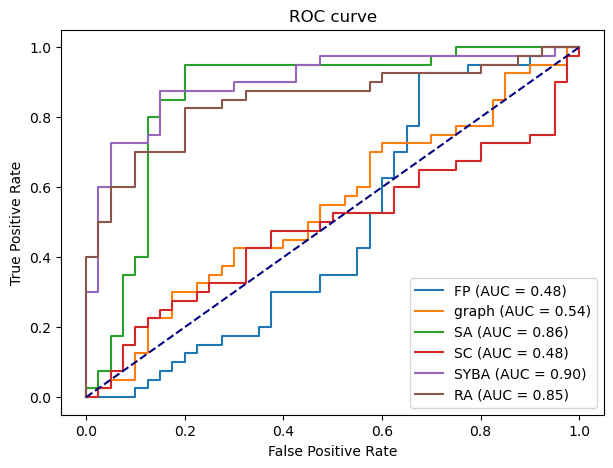

In [61]:
# plot ROC curve
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(roc_curve_fp[0], roc_curve_fp[1], label=f'FP (AUC = {auc_fp:.2f})')
ax.plot(roc_curve_graph[0], roc_curve_graph[1], label= f'graph (AUC = {auc_graph:.2f})')
ax.plot(roc_curve_sa[0], roc_curve_sa[1], label=f'SA (AUC = {auc_sa:.2f})')
ax.plot(roc_curve_sc[0], roc_curve_sc[1], label=f'SC (AUC = {auc_sc:.2f})')
ax.plot(roc_curve_syba[0], roc_curve_syba[1], label=f'SYBA (AUC = {auc_syba:.2f})')
ax.plot(roc_curve_ra[0], roc_curve_ra[1], label=f'RA (AUC = {auc_ra:.2f})')
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc="lower right");


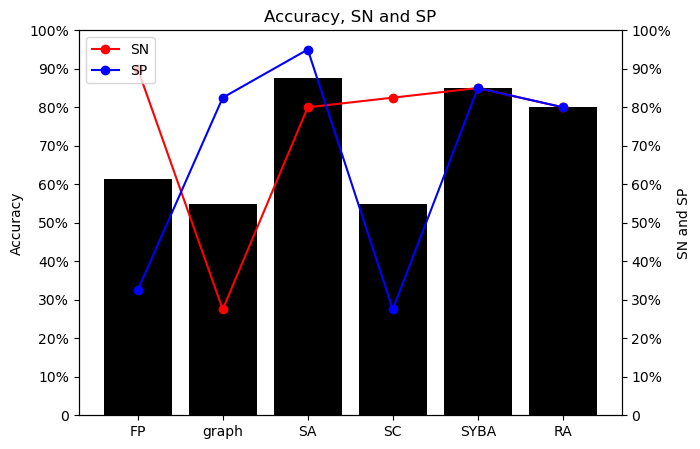

In [62]:
# calculate accuracy, SN and SP
# get splitting score by balancing SN and SP (youden index = max(SN + SP - 1))
import numpy as np
def get_splitting_score(y_true, y_pred, pos_label=1):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=pos_label)
    # calculate youden index
    youden = tpr - fpr
    # locate the index
    idx = np.argmax(youden)
    return thresholds[idx]

def get_acc_sn_sp(y_true, y_pred, threshold, bigger = True):
    if bigger:
        y_pred_bin = np.where(y_pred > threshold, 1, 0)
    else:
        y_pred_bin = np.where(y_pred < threshold, 1, 0)
    acc = accuracy_score(y_true, y_pred_bin)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    sn = tp / (tp + fn)
    sp = tn / (tn + fp)
    return acc, sn, sp

threshold_fp = get_splitting_score(df_fp['label_bin'], df_fp['score'])
threshold_graph = get_splitting_score(df_graph['label_bin'], df_graph['score'])
threshold_sa = get_splitting_score(df_fp['label_bin'], df_fp['SA_score'], pos_label=0)
threshold_sc = get_splitting_score(df_fp['label_bin'], df_fp['SC_score'], pos_label=0)   
threshold_syba = get_splitting_score(df_fp['label_bin'], df_fp['SYBA_score'])
threshold_ra = get_splitting_score(df_fp['label_bin'], df_fp['RAscore'])

acc_fp, sn_fp, sp_fp = get_acc_sn_sp(df_fp['label_bin'], df_fp['score'], threshold_fp)
acc_graph, sn_graph, sp_graph = get_acc_sn_sp(df_graph['label_bin'], df_graph['score'], threshold_graph)
acc_sa, sn_sa, sp_sa = get_acc_sn_sp(df_fp['label_bin'], df_fp['SA_score'], threshold_sa, bigger=False)
acc_sc, sn_sc, sp_sc = get_acc_sn_sp(df_fp['label_bin'], df_fp['SC_score'], threshold_sc, bigger=False)
acc_syba, sn_syba, sp_syba = get_acc_sn_sp(df_fp['label_bin'], df_fp['SYBA_score'], threshold_syba)
acc_ra, sn_ra, sp_ra = get_acc_sn_sp(df_fp['label_bin'], df_fp['RAscore'], threshold_ra)

# plot accuracy, SN and SP
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar([0, 1, 2, 3, 4, 5], [acc_fp, acc_graph, acc_sa, acc_sc, acc_syba, acc_ra], color='k')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['FP', 'graph', 'SA', 'SC', 'SYBA', 'RA'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy, SN and SP')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax2 = ax.twinx()
ax2.plot([0, 1, 2, 3, 4, 5], [sn_fp, sn_graph, sn_sa, sn_sc, sn_syba, sn_ra], color='r', marker='o', label='SN')
ax2.plot([0, 1, 2, 3, 4, 5], [sp_fp, sp_graph, sp_sa, sp_sc, sp_syba, sp_ra], color='b', marker='o', label='SP')
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticklabels(['0', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax2.set_ylabel('SN and SP')
ax2.legend(loc='upper left');


#### Analyse SYBA test set mols

In [4]:
df_fp.head()

,idx,smi,atoms,source,label,SA_score,SC_score,SYBA_score,logP,QED,MW,numheavyatoms,RAscore,score
0,ZINC000504191789,O=CC1=CCC(Br)=N1,8,MC,ES,4.331092,2.060692,-21.772772,1.2663,0.549960,173.997,8,0.711760,-0.3252
1,ZINC000182845317,CSCC(=O)N[C@@H](C)C[S@@](C)=O,12,MC,ES,3.684122,2.434187,31.791560,0.2326,0.704994,209.336,12,0.993623,-1.5460
2,ZINC000000340215,COc1cc(/C=C2\C(=O)N(C)C(=S)N2C)ccc1O,19,MC,ES,2.508790,2.828878,51.942219,1.4304,0.654961,278.333,19,0.963626,0.4830
3,ZINC000461336873,CCN(CC)CCCC1CCN(C(=O)[C@@H]2[C@@H](C)C2(F)F)CC1,22,MC,ES,3.325205,3.879991,32.036718,3.2482,0.719677,316.436,22,0.618622,-3.4880
4,ZINC000352627055,COc1cc(NC(=O)N[C@H]2C[C@@H]2C(F)F)cc(S(C)(=O)=...,22,MC,ES,3.311971,4.335922,55.659051,1.8738,0.860888,334.344,22,0.946026,-6.5660


In [6]:
PandasTools.AddMoleculeColumnToFrame(df_fp, smilesCol='smi', molCol='mol')

In [8]:
# group by label and source
df_ES = df_fp[df_fp['label'] == 'ES']
df_MC_ES = df_ES[df_ES['source'] == 'MC']
df_CP_ES = df_ES[df_ES['source'] == 'CP']
df_HS = df_fp[df_fp['label'] == 'HS']
df_MC_HS = df_HS[df_HS['source'] == 'MC']
df_CP_HS = df_HS[df_HS['source'] == 'CP']

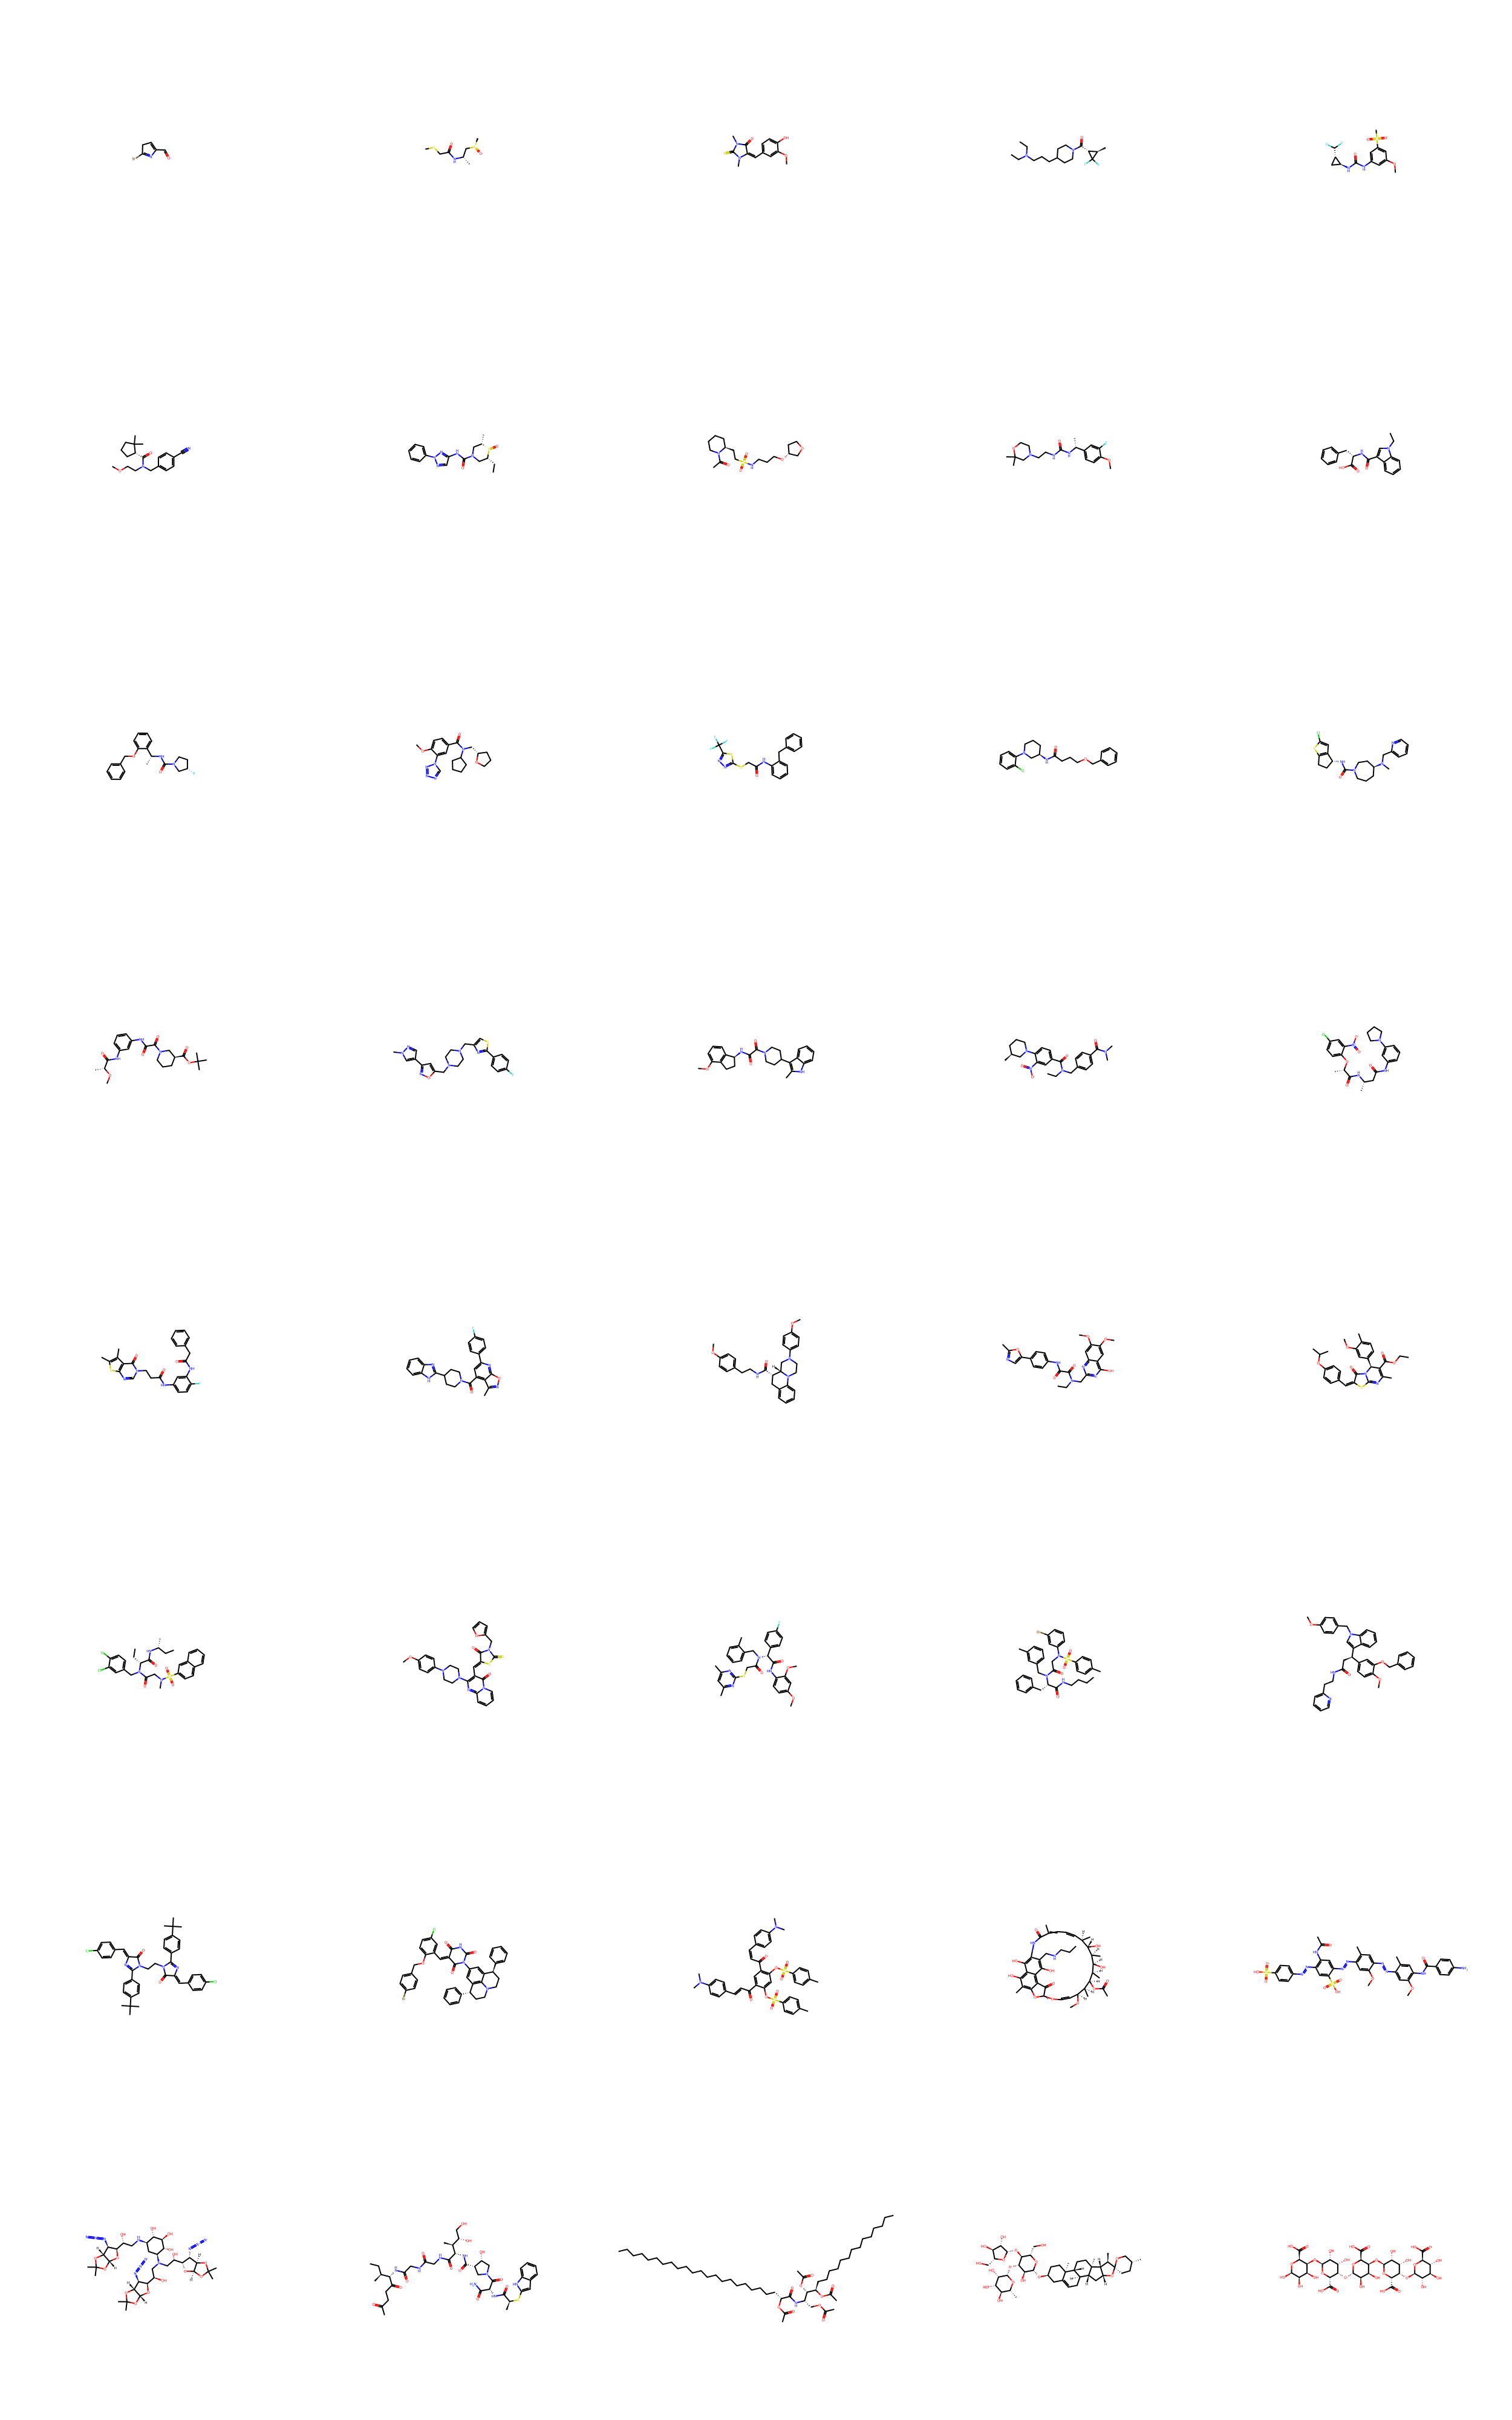

In [20]:
# visualize molecules
Chem.Draw.MolsToGridImage(df_MC_ES['mol'], molsPerRow=5, subImgSize=(500, 500))